In [152]:
%matplotlib inline

In [153]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [154]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

In [155]:
dfm = pd.read_csv('../data/derivaded_3.csv',index_col=0)
print (len(dfm))
dfm = dfm.drop('prcp_plus_12',1)
dfm.head(3)

27721


,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_16,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [156]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [157]:
target = 'prcp_acum_24'

In [158]:
def f(x):
    if x[target] <= 0.0: 
        return 0
    elif x[target] < 50:       
        return 1
    else:
        return 2     

In [159]:
X = dfm[[col for col in dfm.columns]]

In [160]:
X.loc[:,('rain')] = X.apply(f,axis=1)

In [161]:
X.sample(3)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,rain
26451,0.0,920.1,920.8,920.1,29.0,15.7,30.4,17.6,28.5,14.1,...,22.1,21.6,22.1,24.9,27.2,27.9,28.1,28.2,0.0,0
26391,0.0,917.5,917.9,917.5,23.5,15.9,23.9,16.0,22.2,15.6,...,23.6,22.1,20.7,20.6,20.7,20.8,21.1,22.8,0.0,0
24899,1.8,918.7,919.1,918.7,21.3,19.9,21.3,20.0,21.1,19.7,...,22.5,22.6,22.7,22.7,23.0,23.9,24.5,24.8,4.0,1


In [162]:
y = X['prcp_acum_24']
y.sample(3)

24149     0.0
18208     0.0
11142    13.2
Name: prcp_acum_24, dtype: float64

In [163]:
#X.describe()

<h3>Normalization</h3>

In [164]:
col = [c for c in X.columns if c not in ['rain']]

In [165]:
bkp_X = X

In [166]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(-0.8, 0.8))
    
X[col] = scale.fit_transform(X[col])

In [167]:
r = scale.inverse_transform(X[col])
restored = pd.DataFrame(r, index=X[col].index, columns=X[col].columns)

In [168]:
r_X = pd.concat([restored,X['rain']], axis=1)

In [169]:
print (isinstance(r_X, pd.DataFrame))    
print (bkp_X.equals(X))

True
True


<p>Separando o conjunto de treinamento e validação (metade dos 20% separados para validação e testes)</p>

In [170]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=13, stratify = X['rain']) 

<p>Separando o conjunto de testes</p>

In [171]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=13, stratify = X_tmp['rain'])

In [172]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   22176, Training features   327
Validation instances 2773, Validation features 327
Testing instances    2772, Testing features    327


In [173]:
X.groupby('rain').size()

rain
0    14070
1    12294
2     1357
dtype: int64

In [174]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = 3
fn = tf.sigmoid
batch_size = 1000

In [243]:
features = [col for col in X_train.columns if col not in ['rain',target]]
feature_cols = [tf.feature_column.numeric_column(f) for f in features] 

In [244]:
feature_cols

[_NumericColumn(key='prcp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='stp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='temp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dewp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericCo

In [245]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      ,activation_fn=fn
                                      ,model_dir='/tmp/tf_model_17_3')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_model_17_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15b615c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [178]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [179]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [258]:
def only_freatures(df):
    df = df.drop('rain',1)
    df = df.drop('prcp_acum_24',1)
    return df

In [259]:
def balancear(X, y):

    X_resampled, y_resampled, idx_resampled = under.fit_sample(X, X['rain'])

    X = pd.DataFrame(X_resampled, index=idx_resampled, columns = X.columns)
    y = pd.DataFrame(y_resampled, index=idx_resampled, columns =[target])

    X = only_freatures(X)
    
    return X,y

In [260]:
#A, b = balancear(X_train, y_train)

In [232]:
#print (A.loc[(A.index ==11783)].values.sum())
#print (X_train.loc[(X.index ==11783)].values.sum())

In [233]:
#A.loc[(A.index ==11783)]

In [234]:
#X_train.loc[(X.index ==11783)]

In [262]:
evaluations = []  
STEPS = 500  

for i in range(1, 100):    
    
    print ('balanceando...')
    
    A, b = balancear(X_train, y_train)
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(only_freatures(X_val)
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

balanceando...
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:loss = 1014.999, step = 1
INFO:tensorflow:global_step/sec: 2.29255
INFO:tensorflow:loss = 566.19916, step = 101 (43.620 sec)
INFO:tensorflow:global_step/sec: 2.47641
INFO:tensorflow:loss = 892.4087, step = 201 (40.381 sec)
INFO:tensorflow:global_step/sec: 2.50749
INFO:tensorflow:loss = 686.4675, step = 301 (39.881 sec)
INFO:tensorflow:global_step/sec: 2.51796
INFO:tensorflow:loss = 371.56583, step = 401 (39.715 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_17_3/model.ckpt.
INFO:tensorflow:Loss for final step: 877.8743.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:S

KeyboardInterrupt: 

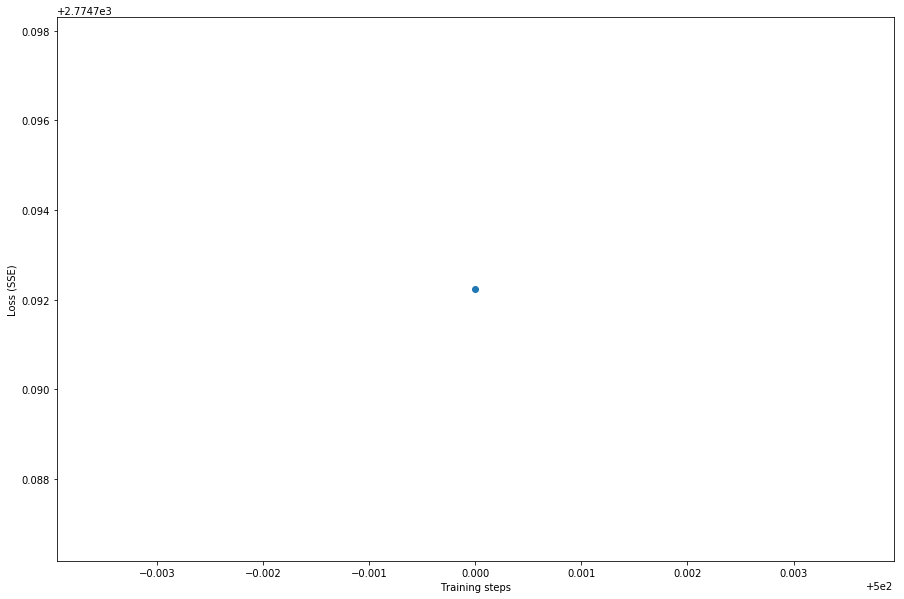

In [263]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [264]:
pred = regressor.predict(input_fn=wx_input_fn(only_freatures(X_test),  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_17_3/model.ckpt-501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [265]:
predictions

array([1.015005, 1.015005, 1.015005, ..., 1.015005, 1.015005, 1.015005],
      dtype=float32)

In [266]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.00
The Mean Absolute Error: 1.73 
The Median Absolute Error: 1.82 


In [267]:
predictions

array([1.015005, 1.015005, 1.015005, ..., 1.015005, 1.015005, 1.015005],
      dtype=float32)

In [268]:
predictions.size

2772

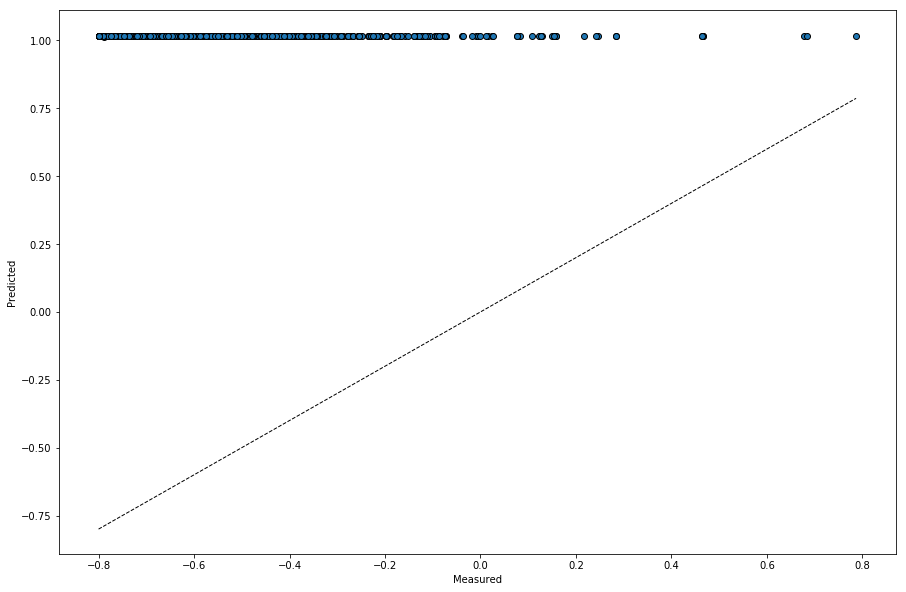

In [269]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()